# Topic 07 : Multiple Testing

In this notebook, we dive into what the literature-recommendation is for performing A/B testing in the presence of more than 1 variant, a problem known as the Multiple Testing problem. This problem also arises when comparing multiple metrics within the same treatment.

As usual, as with other online experimentation topics, we take inspiration from the works of Kohavi et al.

More specifically, in [Kohavi, Tang and Xu, 2018](https://www.cambridge.org/core/books/trustworthy-online-controlled-experiments/D97B26382EB0EB2DC2019A7A7B518F59), the authors mention that there are different angles one can take with the multiple testing problem, from a scale that trades off between usefulness and complexity. They provide the well-known Bonferroni correction as the easiest to implement, although is conservative. They then mention the Benjamini-Hochberg correction. They also provide an additional rule-of-thumb at the end of the chapter. In this notebook, we will cover them all using simulation.

# Unadjusted $\alpha$

This section, we simulate what happens when we don't make any correction.

Remember that the 5% false positive "guarantee" comes from when you have just 1 hypothesis per test. In a multiple-hypothesis scenario, where you have 1 control and X number of treatments, the chance that *at least one* of the treatments being statistically significant is higher than you think.

While not entirely comparable, one way to think about this is the following. Suppose we flip one coin that has a 5% chance of being tails. If you have 2 coins instead of 1, then the chance of getting *at least one tails* can be modeled as $X\sim\text{Binomial}(n=2,p=0.05)$, thus,

$$P(X\geq 1)=1-P(X < 1)=1-P(X=0)=1- {2\choose 0}(0.05^0(1-0.05)^{2-0})=0.0975$$

You have almost a 10% chance of ending up choosing one of the treatments instead of 5!

Note something interesting here though - we made an implicit assumption in our quick math above that each of the coins are independent. Of-course, in practice, this isn't necessarily true. Intuitively, you can probably see that as the correlation between the two coins approaches 1, the false positive converges to our original $\alpha$ of 5%, which was our false positive rate when we only had 1 treatment. This makes sense, because with perfect correlation, multiple treatments are actually just one treatment.

Let's visualize that below.

In [1]:
# packages
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# A function that simulates bernoulli data
def generate_bernoulli(p, size=10000):
    return np.random.binomial(1,p,size=size)

# A function that simulates bernoulli's but allows influence
def generate_bernoulli_with_influence(p, ref_data, influence_factor=0):
    size = len(ref_data)
    modified_p = p*(1-influence_factor) + ref_data*(influence_factor)
    return np.random.binomial(1,modified_p,size=size)

############################################
# To visualize that they are perfectly correlated when influence_factor = 1:
# var1 = generate_bernoulli(0.5)
# var2 = generate_bernoulli_with_influence(0.5, var1, influence_factor=1)
# print(np.corrcoef(var1, var2)[0, 1])
############################################

# run t-test for a control and treatment
def run_ttest(control, treatment):
  t_statistic, p_value = stats.ttest_ind(control, treatment, equal_var=False)
  return p_value

# returns 1 if any one of the list of p_values are below the alpha
def pass_criteria_uncorrected(list_of_p_values, alpha=0.05):
  for pval in list_of_p_values:
    if pval < alpha:
      return 1
  return 0

# simulate the false positive rate for each level of influence_factor
def simulate_multiple_testing_null(n_trials, influence_factor, alpha=0.05):
  pass_list = []
  for i in range(n_trials):
    control = generate_bernoulli(0.5,size=500)
    var1 = generate_bernoulli(0.5,size=500)
    var2 = generate_bernoulli_with_influence(0.5, var1, influence_factor=influence_factor)

    # ttests
    pval1 = run_ttest(control, var1)
    pval2 = run_ttest(control, var2)
    # pass criteria
    pass_list.append(pass_criteria_uncorrected([pval1, pval2], alpha=alpha))
  return np.mean(pass_list)

In [2]:
x = np.arange(0,1.01,0.05)
list_of_false_positives = [simulate_multiple_testing_null(1000, influence_factor = i) for i in x]

(0.0, 0.15)

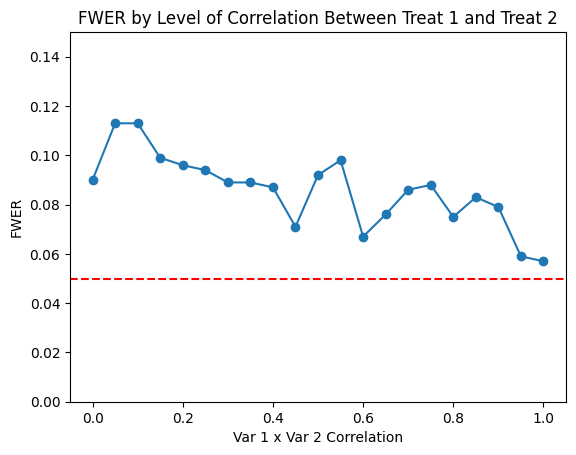

In [14]:
plt.scatter(x, list_of_false_positives)
plt.plot(x, list_of_false_positives)
plt.title('FWER by Level of Correlation Between Treat 1 and Treat 2')
plt.axhline(y=0.05, color='r', linestyle='--')
plt.xlabel('Var 1 x Var 2 Correlation')
plt.ylabel('FWER')
plt.ylim(0,0.15)

## Family-Wise Error Rate

Earlier, we mentioned something about the chances of seeing at least one treatment being rejected even when all are null. This is referred to as the *Family-Wise Error Rate*, the probability of making one or more false discoveries, or type I errors when performing multiple hypotheses tests.

If $V$ is the number of false positives when testing $m$ hypotheses, then the FWER is the probability of making at least one type I error (false positive) in the family,

$$\text{FWER}=\Pr (V\leq 1)=1-\Pr (V=0)$$

Thus, by assuring $\text{FWER}\leq\alpha$, the probability of making one or more type I errors in the family is controlled at level $\alpha$.

You may wonder what it means to have $m$ hypotheses. Unfortunately this is a bit nuanced. There's typically two methods:
- **Scenario 1**: You test Control vs Treatment 1 and Control vs Treatment 2. That's 2 hypotheses
- **Scenario 2**: Perform an Omnibus Test (e.g., ANOVA) that tells you if any of two means are significantly different (but does not specify which). Then, if there is a signal, we perform tests to compare all combinations of the hypotheses ${3\choose 2}=3$

I'm not sure which one is considered "best practice". [Kohavi, Tang and Xu, 2018](https://www.cambridge.org/core/books/trustworthy-online-controlled-experiments/D97B26382EB0EB2DC2019A7A7B518F59) does not mention anything about Ominibus so maybe Scenario 1 is more commonly used. In [Larsen et al., 2023](https://arxiv.org/pdf/2212.11366), a fascinating paper that Kohavi claims was the most read paper in the American Statistician, has the following quote:

"*..with K > 2 variants, determining
which is optimal typically reduces to a pairwise comparison between each treatment and the control.*"

If I am interpreting this line correctly, it appears that Scenario 1 seems to be more commonplace.

Let's move on.

In the case where each comparison is *independent*, as in Treatment 1 and Treatment 2 are not correlated, then FWER equals to

$$\bar\alpha=1-(1-\alpha_{\text{{per comparison}}})^m$$

Thus, we see that as $m$ increases, the value inside the parentheses get smaller, meaning that $\bar\alpha$ gets larger. In other words, the FWER gets larger (assuming, again, that each comparison is independent).

If the Treatments are not perfectly dependent, then we know from Boole's Inequality that

$$\bar\alpha\leq m\cdot\alpha_{\text{{per comparison}}}$$

As we saw in the simulation above, the FWER is maximized when each comparison is independent. The famous Bonferroni Correction is known to be conservative because it works on the assumption that each comparison is independent, which means it needs to correct it by lowering the $\alpha$ more than you would normally need to, since treatments are often not independent.


# The Bonferroni Correction

Denote by $p_i$ the $p$-value for testing $H_i$

Reject $H_i$ if $p_i\leq\frac{\alpha}{m}$

This implies that if we have Control / Treat 1 / Treat 2, then we can only reject any one of the Treatments if the $p$-value is less than $\frac{0.05}{2}=0.025$.

Let's see how this affects our False Positive Rate, based on how correlated Treatment 1 and Treatment 2 are.

In [11]:
# Bonferroni
def pass_criteria_corrected_bonferroni(list_of_p_values, alpha=0.05):
  new_alpha = alpha / len(list_of_p_values)
  for pval in list_of_p_values:
    if pval < new_alpha:
      return 1
  return 0

# also have to rewrite the simulation
def simulate_multiple_testing_null(n_trials, influence_factor, alpha=0.05, correction = 'None'):
  pass_list = []
  for i in range(n_trials):
    control = generate_bernoulli(0.5,size=500)
    var1 = generate_bernoulli(0.5,size=500)
    var2 = generate_bernoulli_with_influence(0.5, var1, influence_factor=influence_factor)

    # ttests
    pval1 = run_ttest(control, var1)
    pval2 = run_ttest(control, var2)
    # pass criteria
    if correction == 'Bonferroni':
      pass_list.append(pass_criteria_corrected_bonferroni([pval1, pval2], alpha=alpha))
    else:
      pass_list.append(pass_criteria_uncorrected([pval1, pval2], alpha=alpha))
  return np.mean(pass_list)

In [12]:
x = np.arange(0,1.01,0.05)
list_of_false_positives_bonf = [simulate_multiple_testing_null(1000, influence_factor = i, correction = 'Bonferroni') for i in x]
list_of_false_positives_unad = [simulate_multiple_testing_null(1000, influence_factor = i, correction = 'None') for i in x]

(0.0, 0.15)

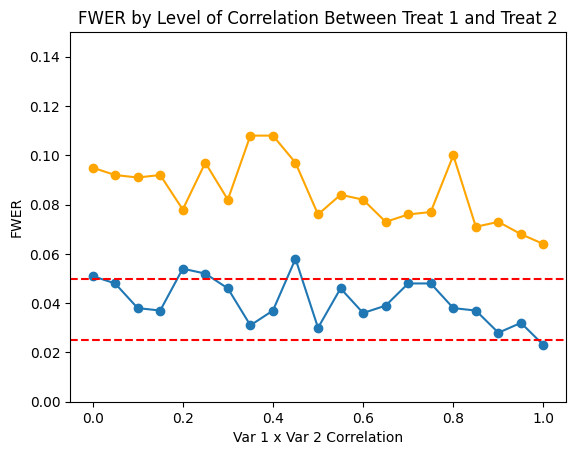

In [15]:
plt.scatter(x, list_of_false_positives_bonf)
plt.plot(x, list_of_false_positives_bonf)
plt.scatter(x, list_of_false_positives_unad,color='orange')
plt.plot(x, list_of_false_positives_unad,color='orange')
plt.title('FWER by Level of Correlation Between Treat 1 and Treat 2')
plt.axhline(y=0.05, color='r', linestyle='--')
plt.axhline(y=0.05/2, color='r', linestyle='--')
plt.xlabel('Var 1 x Var 2 Correlation')
plt.ylabel('FWER')
plt.ylim(0,0.15)

We see how our FWER is about 0.05, the same as our original $\alpha$, when Treatment 1 and Treatment 2 are perfectly correlated. However, we see that FWER decreases as they become more dependent. While it's not bad that error rate goes down, this comes at the expense of *Power*. Remember, we originally chose $\alpha=0.05$ because we wanted to maximize power while coping with a 5% false positive rate.

To finish off, let me copy and paste Wikipedia's section on the criticism around Bonferroni:

*With respect to FWER control, the Bonferroni correction can be conservative if there are a large number of tests and/or the test statistics are positively correlated. The correction comes at the cost of increasing the probability of producing false negatives, i.e., reducing statistical power. There is not a definitive consensus on how to define a family in all cases, and adjusted test results may vary depending on the number of tests included in the family of hypotheses. Such criticisms apply to FWER control in general, and are not specific to the Bonferroni correction.*

# Benjamini-Hochberg Correction

## False Discovery Rate

To discuss Benjamini-Hochberg, we need to discuss False Discovery Rate (FDR), a concept brought forth by Benjamini and Hochberg in 1995. This is an *alternative* method to conceptualize the rate of Type 1 Errors (false positives), especially in the context of multiple testing.

Remember that the way we simulated False Positive Rate (FPR) above was by simulating a bunch of A/A tests, meaning that we assumed null difference for all. This effectively means that we were calculating FPR by

$$FPR=\frac{FP}{FP+TN}$$

Because both FP and TN are in actuality Negative.

Now, remember that the previous methods we learned controls for the FWER, which is capping the false positive rate of *at least one test being significant*.  

In contrast, FDR is:

$$FDR = \frac{FP}{FP+TP}$$

Here, we are dividing FP's by the total number of hypotheses that got rejected. Benjamini-Hochberg is a method that controls the FDR instead of the FWER.

FDR-controlling procedures have greater power, at the cost of increased numbers of Type I errors. In other words, the test no longer caps the false positive rate and instead caps something else while promising that power is increased.

## History

From Wikipedia:
> The FDR has been particularly influential, as it was the first alternative to the FWER to gain broad acceptance in many scientific fields (especially in the life sciences, from genetics to biochemistry, oncology and plant sciences). In 2005, the Benjamini and Hochberg paper from 1995 was identified as one of the 25 most-cited statistical papers.

Some more interesting snippets:
> Prior to the 1995 introduction of the FDR concept, various precursor ideas had been considered in the statistics literature. In 1979, Holm proposed the Holm procedure, a stepwise algorithm for controlling the FWER that is at least as powerful as the well-known Bonferroni adjustment. This stepwise algorithm sorts the p-values and sequentially rejects the hypotheses starting from the smallest p-values.

(You'll see the connection to Holm and BH)

## How it works

A lot of FDR controlling procedures follow a similar format of first having $H_1,...,H_m$ null hypotheses tested and $P_1,...,P_m$ their corresponding $p$-values. We list these $p$-values in ascending order and denote them by $P_{(1)}...P_{(m)}$. A procedure that goes from a small test-statistic to a large one are called "step-up" procedures.

**Benjamimi-Hochberg Procedure**:

Controls the FDR at level $\alpha$.
1. For a given $\alpha$, find the largest $k$ such that $P_{(k)}\leq\frac{k}{m}\alpha$
2. Reject the null hypothesis (i.e., declare discoveries) for all $H_{(i)}$ for $i=1,...,k$.

Geometrically, this corresponds to plotting $P_{(k)}$ vs $k$, drawing a line through the origin with slope $\frac{\alpha}{m}$, and declaring discoveries for all points on the left, up to, and including the last point that is not above the line.

To describe it more intuitively, first rank all the $p$-values (ascending order) indexed by $k$, starting from 1. Then, give each row an adjusted $\alpha$ of $\frac{k}{m}\alpha$ (notice how the last $k$ is just $\alpha$). Then, look for the largest $k$ where the inequality $P_{(k)}\leq\frac{k}{m}\alpha$ is true. Then, reject row that is $k$ or below, even if some of those rows does not pass individually.

This BH procedure is valid when the $m$ tests are independent, and also in various scenarios of dependence, but is not universally valid.

Let's simulate this below, even though we're only using 2 hypotheses:

In [29]:
# Benjamini-Hochberg
def pass_criteria_corrected_bh(list_of_p_values, alpha=0.05):
  list_of_p_values = sorted(list_of_p_values)
  k = np.arange(1,len(list_of_p_values)+1)
  largest_k = 0
  for a,b in (k[::-1], list_of_p_values[::-1]):
    if b <= (a/2)*alpha:
      largest_k = a
      break
  if largest_k == 0:
    return 0
  return 1

# also have to rewrite the simulation
def simulate_multiple_testing_null(n_trials, influence_factor, alpha=0.05, correction = 'None'):
  pass_list = []
  for i in range(n_trials):
    control = generate_bernoulli(0.5,size=500)
    var1 = generate_bernoulli(0.5,size=500)
    var2 = generate_bernoulli_with_influence(0.5, var1, influence_factor=influence_factor)

    # ttests
    pval1 = run_ttest(control, var1)
    pval2 = run_ttest(control, var2)
    # pass criteria
    if correction == 'BH':
      pass_list.append(pass_criteria_corrected_bh([pval1, pval2], alpha=alpha))
    elif correction == 'Bonferroni':
      pass_list.append(pass_criteria_corrected_bonferroni([pval1, pval2], alpha=alpha))
    else:
      pass_list.append(pass_criteria_uncorrected([pval1, pval2], alpha=alpha))
  return np.mean(pass_list)

In [30]:
x = np.arange(0,1.01,0.05)
list_of_false_positives_bh = [simulate_multiple_testing_null(1000, influence_factor = i, correction = 'BH') for i in x]

(0.0, 0.15)

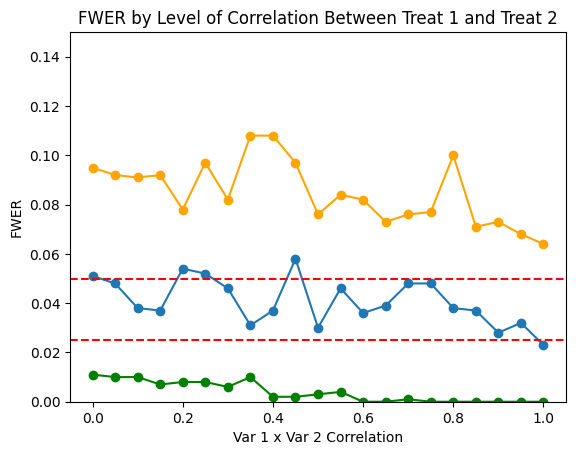

In [31]:
plt.scatter(x, list_of_false_positives_bonf)
plt.plot(x, list_of_false_positives_bonf)
plt.scatter(x, list_of_false_positives_unad,color='orange')
plt.plot(x, list_of_false_positives_unad,color='orange')
plt.scatter(x, list_of_false_positives_bh,color='green')
plt.plot(x, list_of_false_positives_bh,color='green')
plt.title('FWER by Level of Correlation Between Treat 1 and Treat 2')
plt.axhline(y=0.05, color='r', linestyle='--')
plt.axhline(y=0.05/2, color='r', linestyle='--')
plt.xlabel('Var 1 x Var 2 Correlation')
plt.ylabel('FWER')
plt.ylim(0,0.15)

I want to clarify really quick though: one could argue that using this chart to compare FWER rates isn't really accurate. Because as we discussed earlier, Benjamini-Hochberg doesn't even use FWER as a criterion, it caps the FDR instead.

Perhaps in a different notebook I will simulate this for more than just 2 hypotheses.

# Conclusion

Actually, in [Kohavi, Tang and Xu, 2018](https://www.cambridge.org/core/books/trustworthy-online-controlled-experiments/D97B26382EB0EB2DC2019A7A7B518F59), the context in which they discussed Multiple Testing was for the case of having multiple metrics within the same treatment, and this is particularly problematic since there could be hundreds of metrics being viewed.

Now then, what is the real answer on what to do? I'm not sure to be honest, but let me give my best guess given some of the papers I've read:

For the case of multiple *treatments* (You sometimes will, sometimes won't):
- Use pair-wise comparison between control and each treatment and use Bonferroni correction on the $p$-value

For the case of multiple *metrics* in the same treatment (In many companies, this is always true):
- Take [Kohavi, Tang and Xu, 2018](https://www.cambridge.org/core/books/trustworthy-online-controlled-experiments/D97B26382EB0EB2DC2019A7A7B518F59)'s advice of bucketing metrics into 3 categories:
  - primary metrics: use 0.05 as the p-value
  - secondary metrics: use 0.01 as the p-value
  - guardrail metrics: use 0.001 as the p-value
- With this framework, managing hundreds of metrics become more manageable. You'll notice that this framework utilizes a Bayesian line of thinking.